In [ ]:
!pip install ipynbname
!pip install gdown --upgrade
import ipynbname

nb_path = ipynbname.path()  # returns a pathlib.Path object
print("Notebook name:", nb_path.name)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.7 MB/s eta 0:00:00
Notebook name: fileId=1uGuO31ZaUAFoIKq0U7AZ3v0uFPo0eJoF


In [1]:

!pip install rasterio --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 52.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import os
import rasterio
from IPython.display import display
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, jaccard_score, cohen_kappa_score
from sklearn.model_selection import train_test_split


In [4]:
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

2.6.0+cu124
CUDA available: True
GPU name: Tesla T4


In [5]:
from google.colab import files
uploaded = files.upload()


Saving all_DATA.zip to all_DATA.zip


In [6]:
import zipfile
import os

zip_path = "/content/all_DATA.zip"
extract_path = "/content"

# Unzip it
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Confirm it worked
print("Extracted files:", os.listdir(extract_path))


Extracted files: ['.config', 'all_DATA', 'all_DATA.zip', 'sample_data']


In [11]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [160]:
## Set data path

# ## Bangladesh
# RESULTS_PATH = "Result/Bangalesh/DiffCNN_Bangaldesh.xlsx"
# data_dir = "/home/aparajita/Desktop/PhD/Ankita/Data/Flood Data/all_DATA/Bangladesh/GEE_Patches"


# ## Bihar
# RESULTS_PATH = "Result/Bishar/DiffCNN_Bangaldesh.xlsx"
# data_dir = "/home/aparajita/Desktop/PhD/Ankita/Data/Flood Data/all_DATA/Bihar/GEE_Patches"


# ## WestBengal
# RESULTS_PATH = "Result/WB/DiffCNN_Bangaldesh.xlsx"
# data_dir = "/home/aparajita/Desktop/PhD/Ankita/Data/Flood Data/all_DATA/WB/GEE_Patches"


# ## UP
# RESULTS_PATH = "Result/UP/DiffCNN_Bangaldesh.xlsx"
# data_dir = "/home/aparajita/Desktop/PhD/Ankita/Data/Flood Data/all_DATA/UP/GEE_Patches"


## Pakistan
#RESULTS_PATH = r"C:\Users\anshi\Downloads\DiffCNN_Bangaldesh.xlsx"
data_dir = "/content/all_DATA/Bihar/GEE_Patches"



In [161]:
# Set hyperparameters

PATCH_SIZE = 50
BATCH_SIZE = 32
EPOCHS = 50

DIFFUSION_STEPS = 100
MIN_BETA = 1e-4
MAX_BETA = 0.02
betas = np.linspace(MIN_BETA, MAX_BETA, DIFFUSION_STEPS, dtype=np.float32)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas).astype(np.float32)




In [162]:
## Image patch extraction

def extract_patches(image, patch_size=PATCH_SIZE):
    patches = []
    h, w = image.shape
    for i in range(h // patch_size):
        for j in range(w // patch_size):
            patch = image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            patches.append(patch)
    return np.expand_dims(np.array(patches), axis=-1)

def load_and_extract_patches(directory):
    vh_files = sorted([f for f in os.listdir(directory) if f.startswith('S1_VH')])
    ndwi_files = sorted([f for f in os.listdir(directory) if f.startswith('S2_NDWI')])
    mask_files = sorted([f for f in os.listdir(directory) if f.startswith('Mask')])

    print("First 3 VH files:")
    for file in vh_files[:3]:
        print(file)

    print("First 3 NDWI files:")
    for file in ndwi_files[:3]:
        print(file)

    print("First 3 Mask files:")
    for file in mask_files[:3]:
        print(file)

    X_vh, X_ndwi, y = [], [], []
    for vh_file, ndwi_file, mask_file in zip(vh_files, ndwi_files, mask_files):
        with rasterio.open(os.path.join(directory, vh_file)) as src: vh_img = np.nan_to_num(src.read(1))
        with rasterio.open(os.path.join(directory, ndwi_file)) as src: ndwi_img = np.nan_to_num(src.read(1))
        with rasterio.open(os.path.join(directory, mask_file)) as src:
            mask_img = (np.nan_to_num(src.read(1)) > 0).astype(np.float32)

        X_vh.append(extract_patches(vh_img))
        X_ndwi.append(extract_patches(ndwi_img))
        y.append(extract_patches(mask_img))

    X_vh = np.concatenate(X_vh)
    X_ndwi = np.concatenate(X_ndwi)
    y = np.concatenate(y)
    print(f"Class balance: {np.mean(y)*100:.2f}% positive pixels")


    return X_vh, X_ndwi, y


### Each returned array (`X_vh`, `X_ndwi`, `y`) has the shape: (num_patches, patch_height, patch_width, num_channels)

X_vh shape: (50, 50, 50, 1)

50 patches in total (from all input images).

Each patch is 50x50 pixels.

1 channel (since radar and NDWI images are single-band)

In [163]:

def display_patch_table(patch, title, i=0):
    data = patch[i, :5, :5, 0]  # first patch, top-left 5x5
    df = pd.DataFrame(data)
    print(f"\n{title} (shape: {patch[i].shape})")
    display(df.style.format("{:.2f}").set_caption(title))


def show_patch_triplets(X_vh, X_ndwi, y, num_patches=3):
    for i in range(num_patches):
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))
        axs[0].imshow(X_vh[i, :, :, 0], cmap='gray')
        axs[0].set_title("VH Patch")
        axs[0].axis('off')

        axs[1].imshow(X_ndwi[i, :, :, 0], cmap='gray')
        axs[1].set_title("NDWI Patch")
        axs[1].axis('off')

        axs[2].imshow(y[i, :, :, 0], cmap='gray')
        axs[2].set_title("Mask Patch")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

        display_patch_table(X_vh, "VH Patch", i)
        display_patch_table(X_ndwi, "NDWI Patch", i)
        display_patch_table(y, "Mask Patch", i)



In [164]:
## Data augmentation

def augment_dataset(X_vh, X_ndwi, y):
    def flip_h(x): return np.flip(x, axis=2)
    def flip_v(x): return np.flip(x, axis=1)
    def rot90(x): return np.rot90(x, k=1, axes=(1,2))
    def noise(x): return x + np.random.normal(0, 0.01, x.shape)

    augmented = [(X_vh, X_ndwi, y)]
    for fn in [flip_h, flip_v, rot90, noise]:
        augmented.append((fn(X_vh), fn(X_ndwi), fn(y)))
    X_vh_aug, X_ndwi_aug, y_aug = zip(*augmented)
    return np.concatenate(X_vh_aug), np.concatenate(X_ndwi_aug), np.concatenate(y_aug)

In [165]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading and augmenting patches...
First 3 VH files:
S1_VH_patch_0.tif
S1_VH_patch_100.tif
S1_VH_patch_103.tif
First 3 NDWI files:
S2_NDWI_patch_0.tif
S2_NDWI_patch_100.tif
S2_NDWI_patch_103.tif
First 3 Mask files:
Mask_patch_0.tif
Mask_patch_100.tif
Mask_patch_103.tif
Class balance: 90.75% positive pixels
X_vh shape: (62, 50, 50, 1)
X_ndwi shape: (62, 50, 50, 1)
y shape: (62, 50, 50, 1)
X_vh shape: (310, 50, 50, 1)
X_ndwi shape: (310, 50, 50, 1)
y shape: (310, 50, 50, 1)


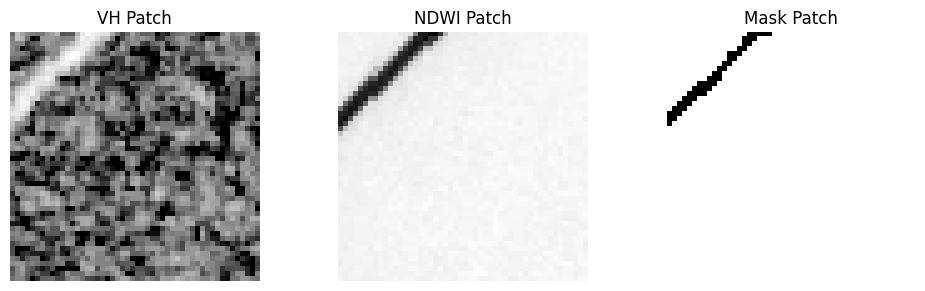


VH Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.26,0.47,0.40,0.34,0.31
1,0.31,0.48,0.44,0.28,0.03
2,0.33,0.33,0.33,0.15,0.23
3,0.34,0.28,0.01,0.11,0.16
4,0.33,0.31,0.32,0.26,0.11



NDWI Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.94,0.95,0.96,0.95,0.94
1,0.94,0.95,0.94,0.95,0.95
2,0.95,0.95,0.95,0.96,0.95
3,0.95,0.95,0.95,0.95,0.96
4,0.95,0.95,0.95,0.95,0.94



Mask Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,1.00,1.00,1.00,1.00,1.00
1,1.00,1.00,1.00,1.00,1.00
2,1.00,1.00,1.00,1.00,1.00
3,1.00,1.00,1.00,1.00,1.00
4,1.00,1.00,1.00,1.00,1.00


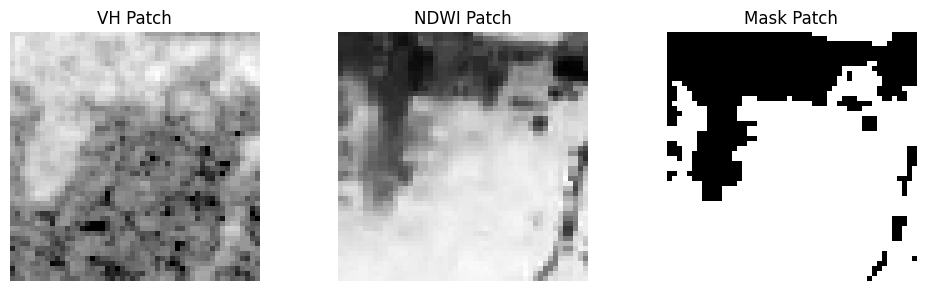


VH Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.66,0.66,0.67,0.67,0.66
1,0.66,0.74,0.73,0.67,0.65
2,0.67,0.75,0.73,0.66,0.63
3,0.68,0.74,0.70,0.69,0.65
4,0.68,0.71,0.69,0.69,0.70



NDWI Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.15,0.14,0.15,0.15,0.13
1,0.17,0.17,0.17,0.14,0.14
2,0.16,0.17,0.17,0.15,0.15
3,0.16,0.16,0.16,0.14,0.13
4,0.14,0.15,0.15,0.14,0.14



Mask Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00


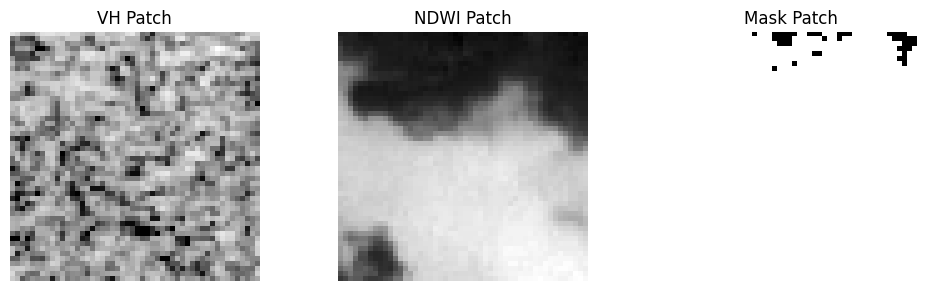


VH Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.45,0.42,0.34,0.34,0.34
1,0.21,0.27,0.16,0.13,0.11
2,0.15,0.24,0.24,0.23,0.19
3,0.18,0.31,0.31,0.33,0.25
4,0.16,0.18,0.18,0.19,0.08



NDWI Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.53,0.53,0.54,0.53,0.51
1,0.55,0.54,0.54,0.53,0.52
2,0.57,0.54,0.54,0.53,0.53
3,0.60,0.55,0.56,0.54,0.53
4,0.60,0.57,0.57,0.56,0.55



Mask Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,1.00,1.00,1.00,1.00,1.00
1,1.00,1.00,1.00,1.00,1.00
2,1.00,1.00,1.00,1.00,1.00
3,1.00,1.00,1.00,1.00,1.00
4,1.00,1.00,1.00,1.00,1.00


X shape: (310, 50, 50, 2)


In [166]:
## Load and visualize data

print("Loading and augmenting patches...")
X_vh, X_ndwi, y = load_and_extract_patches(data_dir)
# Print dimensions
print(f"X_vh shape: {X_vh.shape}")
print(f"X_ndwi shape: {X_ndwi.shape}")
print(f"y shape: {y.shape}")
# show_patch_triplets(X_vh, X_ndwi, y, num_patches=3)
X_vh = (X_vh - X_vh.min()) / (X_vh.max() - X_vh.min())
X_ndwi = (X_ndwi - X_ndwi.min()) / (X_ndwi.max() - X_ndwi.min())
X_vh, X_ndwi, y = augment_dataset(X_vh, X_ndwi, y)
# Print dimensions
print(f"X_vh shape: {X_vh.shape}")
print(f"X_ndwi shape: {X_ndwi.shape}")
print(f"y shape: {y.shape}")
show_patch_triplets(X_vh, X_ndwi, y, num_patches=3)
X = np.concatenate([X_vh, X_ndwi], axis=-1)
print(f"X shape: {X.shape}")


In [167]:
print(X_vh.shape)
print(X_ndwi.shape)
print(y.shape)


(310, 50, 50, 1)
(310, 50, 50, 1)
(310, 50, 50, 1)


In [169]:
import torch
import numpy as np

X_vh = X_vh.astype(np.float32)
X_ndwi = X_ndwi.astype(np.float32)
y = y.astype(np.float32)

X_vh_flat = X_vh.reshape(310, 2500)
X_ndwi_flat = X_ndwi.reshape(310, 2500)

X_combined = np.stack([X_vh_flat, X_ndwi_flat], axis=1)

X_combined_tensor = torch.tensor(X_combined, dtype=torch.float32)

y_tensor = torch.tensor(y.reshape(310, -1), dtype=torch.float32)


In [170]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN1D(nn.Module):
    def __init__(self, in_channels=2):
        super(CNN1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=1)  # Output 1 value per timestep

    def forward(self, x):  # x: [batch, channels, seq_len]
        x = F.relu(self.conv1(x))  # [batch, 32, 2500]
        x = F.relu(self.conv2(x))  # [batch, 64, 2500]
        x = self.conv3(x)          # [batch, 1, 2500]
        return x.squeeze(1)        # [batch, 2500]  (match your target y shape)


In [171]:
X_train, X_temp, y_train, y_temp = train_test_split(X_combined_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

torch.Size([217, 2, 2500]) torch.Size([46, 2, 2500]) torch.Size([47, 2, 2500])


In [172]:
from torch.utils.data import DataLoader, TensorDataset

# Dataset & Dataloader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16)

# Model, optimizer, loss
model = CNN1D(in_channels=2).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

# Training
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to('cuda'), yb.to('cuda')

        # Simulate time embedding input (e.g., 0 for now)
        t = torch.zeros((xb.shape[0], 1)).to('cuda')

        optimizer.zero_grad()
        out = model(xb).squeeze(1)  # shape: (B, 2500)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/50, Loss: 0.5636
Epoch 2/50, Loss: 0.3803
Epoch 3/50, Loss: 0.2914
Epoch 4/50, Loss: 0.2582
Epoch 5/50, Loss: 0.2214
Epoch 6/50, Loss: 0.1792
Epoch 7/50, Loss: 0.1391
Epoch 8/50, Loss: 0.1103
Epoch 9/50, Loss: 0.0919
Epoch 10/50, Loss: 0.0856
Epoch 11/50, Loss: 0.0804
Epoch 12/50, Loss: 0.0765
Epoch 13/50, Loss: 0.0740
Epoch 14/50, Loss: 0.0755
Epoch 15/50, Loss: 0.0752
Epoch 16/50, Loss: 0.0726
Epoch 17/50, Loss: 0.0710
Epoch 18/50, Loss: 0.0678
Epoch 19/50, Loss: 0.0658
Epoch 20/50, Loss: 0.0637
Epoch 21/50, Loss: 0.0627
Epoch 22/50, Loss: 0.0599
Epoch 23/50, Loss: 0.0594
Epoch 24/50, Loss: 0.0615
Epoch 25/50, Loss: 0.0566
Epoch 26/50, Loss: 0.0577
Epoch 27/50, Loss: 0.0547
Epoch 28/50, Loss: 0.0532
Epoch 29/50, Loss: 0.0523
Epoch 30/50, Loss: 0.0503
Epoch 31/50, Loss: 0.0504
Epoch 32/50, Loss: 0.0484
Epoch 33/50, Loss: 0.0482
Epoch 34/50, Loss: 0.0472
Epoch 35/50, Loss: 0.0456
Epoch 36/50, Loss: 0.0439
Epoch 37/50, Loss: 0.0430
Epoch 38/50, Loss: 0.0420
Epoch 39/50, Loss: 0.

In [173]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [174]:
import numpy as np
import pandas as pd
import time
import torch
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, jaccard_score, cohen_kappa_score
)


In [175]:
def compute_metrics(phase, true_labels, predicted_labels):
    flat_true = np.ravel(true_labels)
    flat_pred = np.ravel(predicted_labels)

    return {
        "Timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "Phase": phase,
        "Accuracy": accuracy_score(flat_true, flat_pred),
        "Balanced Accuracy": balanced_accuracy_score(flat_true, flat_pred),
        "Precision": precision_score(flat_true, flat_pred, zero_division=0),
        "Recall": recall_score(flat_true, flat_pred),
        "F1 Score": f1_score(flat_true, flat_pred),
        "IoU": jaccard_score(flat_true, flat_pred),
        "Cohen Kappa": cohen_kappa_score(flat_true, flat_pred),
        "Positive %": round(np.mean(flat_true) * 100, 2),
    }


In [176]:
def evaluate_and_log(y_true, y_pred, csv_path, phase):
    metrics = compute_metrics(phase, y_true, y_pred)
    df = pd.DataFrame([metrics])

    # Append or create CSV
    if not pd.io.common.file_exists(csv_path):
        df.to_csv(csv_path, index=False)
    else:
        df.to_csv(csv_path, mode='a', header=False, index=False)

    print(f"✅ Metrics logged for {phase} phase.")


In [177]:
def get_all_preds(loader, model):
    all_preds = []
    all_true = []
    model.eval()

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            batch_size = X_batch.size(0)

            preds = model(X_batch)
            preds = torch.sigmoid(preds).squeeze(dim=1)  # [batch, 2500] if needed

            preds = (preds > 0.5).float().cpu().numpy()
            all_preds.append(preds)
            all_true.append((y_batch > 0.5).float().cpu().numpy())

    return np.concatenate(all_true), np.concatenate(all_preds)


In [179]:
results_path = "cnn_Bihar.csv"

# Train Set Evaluation
train_true, train_pred = get_all_preds(train_loader, model)
evaluate_and_log(train_true, train_pred, results_path, "Train")

# Validation Set Evaluation
val_true, val_pred = get_all_preds(val_loader, model)
evaluate_and_log(val_true, val_pred, results_path, "Validation")

# Test Set Evaluation
test_true, test_pred = get_all_preds(test_loader, model)
evaluate_and_log(test_true, test_pred, results_path, "Test")


✅ Metrics logged for Train phase.
✅ Metrics logged for Validation phase.
✅ Metrics logged for Test phase.
